In [1]:
# Use BPR and "SVD" to predict user ranking/rating of each movie

In [2]:
import tensorflow as tf
import numpy as np
import os
import time
import datetime
from tensorflow.contrib import learn
import re
import itertools
from collections import Counter
from collections import defaultdict
import gzip
import struct
import smtplib
from email.mime.text import MIMEText
from IPython.display import Audio
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
basedir = '/home/tvromen/research/subtitles'

class Flags(object):
    def __init__(self):
        # Data loading params
        self.val_sample_percentage = .1 # Percentage of the training data to use for validation
        self.ratings_file = os.path.join(basedir, 'ml-20m/ratings.csv') # Data source for the ratings
        self.text_data_file = os.path.join(basedir, 'movielens-subtitles-1024.txt') # Data source

        self.max_lines = 1000000

        # Model Hyperparameters
        self.embedding_dim = 64 # Dimensionality of user & movie vectors (default: 128)

        #self.max_vocab_size = 100000
        #self.vocab_embedding_dim = 300 # Dimensionality of character embedding (default: 128)
        #self.filter_sizes = "3,4,5" # Comma-separated filter sizes (default: '3,4,5')
        #self.num_filters = 128 # Number of filters per filter size (default: 128)
        #self.dropout_keep_prob = 0.5 # Dropout keep probability (default: 0.5)

        #self.words_in_scene = 64
        #self.num_scenes = 16

        # Training parameters
        self.batch_size = 128 # Batch Size (default: 128)
        self.num_epochs = 10 # Number of training epochs (default: 8)
        self.summary_every = 100
        self.evaluate_every = 1000 # Evaluate model on val set after this many steps (default: 100)
        self.checkpoint_every = 2000 # Save model after this many steps (default: 100)
        self.num_checkpoints = 3 # Number of checkpoints to store (default: 5)
        # Misc Parameters
        self.allow_soft_placement = True # Allow device soft device placement
        self.log_device_placement = True # Log placement of ops on devices

FLAGS = Flags()

In [4]:
# Data helpers

class IdAssigner:
    def __init__(self):
        self.forward = dict()
        self.reverse = dict()
        self.next_id = 0
    def get_id(self, x):
        if x not in self.forward:
            self.forward[x] = self.next_id
            self.reverse[self.next_id] = x
            self.next_id += 1
        return self.forward[x]
    def get_reverse_id(self, id_):
        return self.reverse[id_]
    def get_next_id(self):
        return self.next_id

class Subtitles:
    """
    Class that is in charge of subtitles
    """
    def __init__(self, data_file):
        samples = list(open(data_file, 'r').readlines())
        samples = [s.strip() for s in samples]
        ids = [int(s.split()[0]) for s in samples]
        x_text = [' '.join(s.split()[1:]) for s in samples]
        self.subs = dict()
        for id_,txt in zip(ids, x_text):
            self.subs[id_] = txt


class RatingsData:
    """
    Loads the ratings from the file. Returns an array x where each row is [user_id, movie_id]
    The movie_id is not the original movie_id, but rather a new id which is allocated densely (no skips)
    """

    def __init__(self, data_file, max_lines, subs):
        self.id_assigner = IdAssigner()
        self.movies_per_user = defaultdict(list) # map user_id -> [movie_id_1, movie_id_2, ...]
        self.movie_watch_count = defaultdict(int)   # number of times watched per new_movie_id
        # load file
        x = self._load_file(data_file, max_lines, subs)
        x = self._sort_dataset(x)
        x = x[['user_id', 'movie_id', 'rating']]
        # split training/validation:
        # the training set is all movies for each user except the last (in chronological order)
        # validation set is the last movie for each user
        user_ids = x['user_id']
        is_last = (user_ids != np.append(user_ids[1:], -1))
        self.train = x[~is_last]
        self.val = x[is_last]

    def _load_file(self, data_file, max_lines, subs):
        print("Loading data...")
        x = np.zeros(
            max_lines,
            dtype=[('valid',np.bool), ('user_id',np.int32), ('movie_id', np.int32), ('rating', np.float32), ('timestamp', np.int32)]
        )
        with open(data_file) as f:
            _ = f.readline() # skip first line
            for i,line in enumerate(f.readlines()):
                if i % 1000000 == 0:
                    print('{}...'.format(i))
                if i == max_lines:
                    break
                words = line.split(',')
                user_id  = int(words[0])
                movie_id = int(words[1])
                rating   = float(words[2])
                timestamp = int(words[3])
                if movie_id not in subs.subs:
                    # movie doesn't have subtitles
                    continue
                new_movie_id = self.id_assigner.get_id(movie_id)
                x[i] = (True, user_id, new_movie_id, rating, timestamp)
                self.movies_per_user[user_id].append(new_movie_id)
                self.movie_watch_count[new_movie_id] += 1
        valid = (x['valid'] != 0)
        x = x[valid]
        # center the ratings around 0
        x['rating'] = x['rating'] - np.mean(x['rating'])
        return x[['user_id', 'movie_id', 'rating', 'timestamp']]

    def _sort_dataset(self, x):
        # sort by user and timestamp - use stable sorting algorithm
        x = x[x['timestamp'].argsort(kind='mergesort')]  # secondary sort key
        x = x[x['user_id'].argsort(kind='mergesort')]  # primary sort key
        return x

    def get_num_users(self):
        return max(self.movies_per_user.keys()) + 1 # starts from 1

    def get_num_movies(self):
        return self.id_assigner.get_next_id()

    def get_train(self, shuffle=True):
        if shuffle:
            shuffle_indices = np.random.permutation(np.arange(len(self.train)))
            return self.train[shuffle_indices]
        else:
            return self.train

    def get_val(self, shuffle=True):
        if shuffle:
            shuffle_indices = np.random.permutation(np.arange(len(self.val)))
            return self.val[shuffle_indices]
        else:
            return self.val

    ## TODO: generate negative with equal probability
    ## TODO: this doesn't really use movie_id...
    def _batch_iter_generate_neg(self, user_id, movie_id):
        """
        Generates a batch res of same length as the inputs, such that for each tuple in (user_id, movie_id, res),
        the item movie_id is ranked same or higher (by the user) than the corresponding item in res.
        Also includes movies that haven't been watched. The movies are chosen according to popularity.
        inputs:
            user_id is array of length n
            movie_id is array of length n
        output:
            res is array of length n
        """
        n = len(user_id)
        assert len(movie_id) == n, len(movie_id)
        # count number of watches
        num_movies = self.id_assigner.get_next_id()
        watch_counts = np.array([self.movie_watch_count[i] for i in range(num_movies)], dtype=np.float32)
        total_watches = np.sum(watch_counts)
        assert(total_watches > 0)
        res = np.zeros([n], dtype=np.int32)
        # do it per user to speed up things
        i = 0
        while i < n:
            curr_user_id = user_id[i]
            user_start_idx = i
            while i < n and user_id[i] == curr_user_id:
                i += 1
                if i % 1000000 == 0:
                    print('{}...'.format(i))
            if i < n:
                assert user_id[i] > curr_user_id, 'input needs to be sorted by user, otherwise this code it really inefficient'
            user_end_idx = i # after-last
            # update watch counts: subtract this user's watches
            to_mask = np.zeros([num_movies], dtype=np.bool)
            for j in self.movies_per_user[curr_user_id]:
                to_mask[j] = True
            total_masked = np.sum(watch_counts[to_mask])
            p = (watch_counts * (1-to_mask)) / (total_watches - total_masked)
            res[user_start_idx:user_end_idx] = \
                np.random.choice(num_movies, size=[user_end_idx-user_start_idx], p=p)
            if False: # too slow
                for j in range(user_start_idx, user_end_idx):
                    assert res[j] not in self.movies_per_user[curr_user_id]
        return res

    def batch_iter(self, x, batch_size, num_epochs, shuffle=True):
        """
        Generates the pair for each datapoint, and then
        generates a batch iterator.
        """
        assert type(x) == np.ndarray, type(x)
        data_size = len(x)
        # split to batches
        num_batches_per_epoch = ((data_size - 1) // batch_size) + 1
        for epoch in range(num_epochs):
            # generate the pair
            neg = self._batch_iter_generate_neg(x['user_id'], x['movie_id'])
            # Shuffle the data
            shuffle_indices = np.arange(data_size)
            if shuffle:
                shuffle_indices = np.random.permutation(shuffle_indices)
            x_shuffled = x[shuffle_indices]
            neg = neg[shuffle_indices]
            for batch_num in range(num_batches_per_epoch):
                start_index = batch_num * batch_size
                end_index = min((batch_num + 1) * batch_size, data_size)
                x_batch = x[start_index:end_index]
                batch_neg = neg[start_index:end_index]
                batch_user_id = x_batch['user_id']
                batch_pos = x_batch['movie_id']
                batch_pos_neg = np.stack([batch_pos,batch_neg], axis=-1)
                batch_rating = x_batch['rating']
                yield (batch_user_id, batch_pos_neg, batch_rating)


In [5]:
# Data Preparation
# ==================================================

# Load data
subs = Subtitles(FLAGS.text_data_file)
ratings = RatingsData(FLAGS.ratings_file, FLAGS.max_lines, subs)

np.random.seed(1234)

x_train = ratings.get_train(shuffle=False)
x_val = ratings.get_val(shuffle=False)

print("Train/Val split: {:d}/{:d}".format(len(x_train), len(x_val)))

num_users = ratings.get_num_users()
num_movies = ratings.get_num_movies()

print('Num users: {}'.format(num_users))
print('Num movies: {}'.format(num_movies))

Loading data...
0...
1000000...
Train/Val split: 976945/6743
Num users: 6744
Num movies: 11920


In [27]:
def get_dynamic_tensor_shape(x):
    """
    Calculate the tensor shape. Use a plain number where possible and a tensor elsewhere.
    x is a tensor of some shape.
    returns a list with the dimensions of x.
    """
    shape_tensor = tf.shape(x)
    shape = list(x.get_shape())
    for i in range(len(shape)):
        shape[i] = shape[i].value
        if shape[i] is None:
            # use tensor to represent the dimension
            shape[i] = shape_tensor[i]
    return shape


def embedding_lookup_layer(x, vocab_size, embedding_dim, variable_scope, reuse=False):
    """
    Lookup embedding
    x is tensor of shape (d_1, d_2, ..., d_n) and type int32
    result is tensor of shape (d_1, d_2, ..., d_n, embedding_dim) of n+1 dimensions and type DT_FLOAT
    """
    with tf.variable_scope(variable_scope, reuse=reuse):
        W = tf.get_variable(
            'W',
            shape=[vocab_size, embedding_dim],
            initializer=tf.contrib.layers.xavier_initializer(),
            regularizer=tf.contrib.layers.l2_regularizer(1.)
        )
    x_embedded = tf.nn.embedding_lookup(W, x)
    return x_embedded

def bias_lookup_layer(x, vocab_size, variable_scope, reuse=False):
    """
    Lookup embedding
    x is tensor of shape (d_1, d_2, ..., d_n) and type int32
    result is tensor of same shape in x and type DT_FLOAT
    """
    with tf.variable_scope(variable_scope, reuse=reuse):
        b = tf.get_variable(
            'b',
            shape=[vocab_size, 1],
            initializer=tf.zeros_initializer(),
            regularizer=tf.contrib.layers.l2_regularizer(1.)
        )
    x_bias = tf.squeeze(tf.nn.embedding_lookup(b, x), -1)
    return x_bias

def fc_layer(x, output_size, variable_scope, reuse=False):
    """
    Fully-connected layer
    x has shape (batch_size, d_2)
    result has shape (batch_size, output_size)
    """
    shape = get_dynamic_tensor_shape(x)
    assert len(shape) == 2
    ## TODO: regularization
    with tf.variable_scope(variable_scope, reuse=reuse):
        W = tf.get_variable(
            "W",
            shape=[shape[1], output_size],
            initializer=tf.contrib.layers.xavier_initializer())
        b = tf.get_variable(
            "b",
            shape=[output_size],
            initializer=tf.contrib.layers.xavier_initializer())
    result = tf.nn.xw_plus_b(x, W, b, name="fc")
    return result


class PredictionModel(object):
    """
    A neural network for predicting per-user movie ratings.
    The input to the network is the user_id and movie_id.
    """
    def __init__(self, num_users, num_movies, embedding_dim, l2_reg_lambda, loss_mult_ranking, loss_mult_rating):

        assert num_users >= 1
        self.num_users = num_users
        assert num_movies >= 1
        self.num_movies = num_movies
        assert embedding_dim >= 1
        self.embedding_dim = embedding_dim
        assert l2_reg_lambda >= 0

        # Placeholders for input, output and dropout
        self.input_user_id = tf.placeholder(tf.int32, [None], name="input_user_id")
        self.input_pos_neg = tf.placeholder(tf.int32, [None, 2], name="input_pos_neg")
        self.input_movie_id = tf.placeholder(tf.int32, [None], name="input_movie_id")
        self.input_rating = tf.placeholder(tf.float32, [None], name="input_rating")
        #self.dropout_keep_prob = tf.placeholder(tf.float32, name="dropout_keep_prob") # TODO: do we need dropout?

        asrt1 = tf.assert_equal(tf.shape(self.input_user_id)[0], tf.shape(self.input_pos_neg)[0])
        asrt2 = tf.assert_equal(tf.shape(self.input_user_id)[0], tf.shape(self.input_rating)[0])

        # embedding lookup layer
        with tf.device('/cpu:0'), tf.name_scope('embedding_lookup'), tf.control_dependencies([asrt1]):
            user_embedding = embedding_lookup_layer(self.input_user_id, self.num_users, self.embedding_dim, 'user_embedding')
            user_bias = bias_lookup_layer(self.input_user_id, self.num_users, 'user_embedding')
            movie_embedding = embedding_lookup_layer(self.input_pos_neg, self.num_movies, self.embedding_dim, 'movie_embedding')
            movie_bias = bias_lookup_layer(self.input_pos_neg, self.num_movies, 'movie_embedding')
            pos_embedding = movie_embedding[:,0,:]
            neg_embedding = movie_embedding[:,1,:]
            pos_bias = movie_bias[:,0]
            neg_bias = movie_bias[:,1]

        # ranking prediction (BPR)
        with tf.name_scope('ranking_prediction'):
            delta_embedding = pos_embedding - neg_embedding
            delta_bias = pos_bias - neg_bias
            self.ranking_prediction = tf.reduce_sum(user_embedding * delta_embedding, axis=1) + delta_bias

        # rating prediction ("SVD for recommender systems")
        with tf.name_scope('rating_prediction'):
            self.rating_prediction = tf.reduce_sum(user_embedding * pos_embedding, axis=1) + user_bias + pos_bias

        # Calculate loss
        with tf.name_scope('ranking_loss'):
            #losses = tf.log(tf.sigmoid(-self.ranking_prediction) + 0.01)
            self.ranking_loss = tf.reduce_mean(tf.sigmoid(-self.ranking_prediction)) ## TODO use log of sigmoid

        with tf.name_scope('rating_loss'):
            self.rating_loss = tf.reduce_mean(tf.square(self.input_rating - self.rating_prediction))

        with tf.name_scope('loss'):
            reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
            self.loss = \
                (loss_mult_ranking * self.ranking_loss) \
                + (loss_mult_rating * self.rating_loss) \
                + l2_reg_lambda * sum(reg_losses)

        # Ranking accuracy
        with tf.name_scope('ranking_accuracy'):
            self.ranking_accuracy = tf.reduce_mean(tf.cast(self.ranking_prediction > 0, tf.float32))

        # Rating accuracy = RMSE (for now...)
        # (this is actually error rate, and not accuracy, i.e. lower is better)
        with tf.name_scope('rating_accuracy'):
            self.rating_accuracy = tf.sqrt(self.rating_loss)


    def get_ranking_predictions(self):
        asrt1 = tf.assert_equal(tf.shape(self.input_user_id)[0], 1)
        with tf.device('/cpu:0'), tf.name_scope('embedding_lookup'), tf.control_dependencies([asrt1]):
            user_embedding = embedding_lookup_layer(self.input_user_id, self.num_users, self.embedding_dim, 'user_embedding', True)
            movie_embedding = embedding_lookup_layer(self.input_movie_id, self.num_movies, self.embedding_dim, 'movie_embedding', True)
            movie_bias = bias_lookup_layer(self.input_movie_id, self.num_movies, 'movie_embedding', True)
        prediction = tf.reduce_sum(user_embedding * movie_embedding, axis=1) + movie_bias
        return prediction

    def get_rating_predictions(self):
        asrt1 = tf.assert_equal(tf.shape(self.input_user_id)[0], 1)
        with tf.device('/cpu:0'), tf.name_scope('embedding_lookup'), tf.control_dependencies([asrt1]):
            user_embedding = embedding_lookup_layer(self.input_user_id, self.num_users, self.embedding_dim, 'user_embedding', True)
            user_bias = bias_lookup_layer(self.input_user_id, self.num_users, 'user_embedding', True)
            movie_embedding = embedding_lookup_layer(self.input_movie_id, self.num_movies, self.embedding_dim, 'movie_embedding', True)
            movie_bias = bias_lookup_layer(self.input_movie_id, self.num_movies, 'movie_embedding', True)
        prediction = tf.reduce_sum(user_embedding * movie_embedding, axis=1) + user_bias + movie_bias
        return prediction


In [28]:
# Training
# ==================================================

def train(
    cnn, sess, starter_learning_rate, learning_rate_decay_every, learning_rate_decay_by
):
    last_accuracy = 0

    # Define Training procedure
    global_step = tf.Variable(0, name="global_step", trainable=False)
    #optimizer = tf.train.AdamOptimizer(1e-3)
    learning_rate = tf.train.exponential_decay(
        starter_learning_rate, global_step, learning_rate_decay_every,
        learning_rate_decay_by, staircase=True)
    optimizer = tf.train.AdamOptimizer(learning_rate)

    grads_and_vars = optimizer.compute_gradients(cnn.loss)
    train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step)

    # Keep track of gradient values and sparsity (optional)
    grad_summaries = []
    #for g, v in grads_and_vars:
    for g,v in []:
        if g is not None:
            grad_hist_summary = tf.summary.histogram("{}/grad/hist".format(v.name), g)
            sparsity_summary = tf.summary.scalar("{}/grad/sparsity".format(v.name), tf.nn.zero_fraction(g))
            grad_summaries.append(grad_hist_summary)
            grad_summaries.append(sparsity_summary)
    #grad_summaries_merged = tf.summary.merge(grad_summaries)

    # Output directory for models and summaries
    timestamp = str(int(time.time()))
    out_dir = os.path.abspath(os.path.join(os.path.curdir, "runs", timestamp))
    print("Writing to {}\n".format(out_dir))

    # Summaries for loss and accuracy
    rating_loss_summary = tf.summary.scalar("rating_loss", cnn.rating_loss)
    loss_summary = tf.summary.scalar("loss", cnn.loss)
    acc_summary = tf.summary.scalar("accuracy", cnn.rating_accuracy)
    learning_rate_summary = tf.summary.scalar("learning_rate", learning_rate)

    # Train Summaries
    train_summary_op = tf.summary.merge([rating_loss_summary, loss_summary, acc_summary, learning_rate_summary])#, grad_summaries_merged])
    train_summary_dir = os.path.join(out_dir, "summaries", "train")
    train_summary_writer = tf.summary.FileWriter(train_summary_dir, sess.graph)

    # Val summaries
    val_summary_op = tf.summary.merge([rating_loss_summary, loss_summary, acc_summary, learning_rate_summary])
    val_summary_dir = os.path.join(out_dir, "summaries", "val")
    val_summary_writer = tf.summary.FileWriter(val_summary_dir, sess.graph)

    # Checkpoint directory. Tensorflow assumes this directory already exists so we need to create it
    checkpoint_dir = os.path.abspath(os.path.join(out_dir, "checkpoints"))
    checkpoint_prefix = os.path.join(checkpoint_dir, "model")
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    saver = tf.train.Saver(tf.global_variables(), max_to_keep=FLAGS.num_checkpoints)

    # Initialize all variables
    sess.run(tf.global_variables_initializer())

    def train_step(batch_user_id, batch_pos_neg, batch_rating):
        """
        A single training step 
        """
        feed_dict = {
            cnn.input_user_id: batch_user_id,
            cnn.input_pos_neg: batch_pos_neg,
            cnn.input_rating: batch_rating
        }
        pretrain_ranking_accuracy, pretrain_rating_accuracy = sess.run(
            [cnn.ranking_accuracy, cnn.rating_accuracy],
            feed_dict)
        sess.run(train_op, feed_dict)
        step, loss, ranking_accuracy, rating_accuracy, rate = sess.run(
            [global_step, cnn.loss, cnn.ranking_accuracy, cnn.rating_accuracy, learning_rate],
            feed_dict)
        if step % FLAGS.summary_every == 0:
            summaries = sess.run(train_summary_op, feed_dict)
            train_summary_writer.add_summary(summaries, step)
        time_str = datetime.datetime.now().isoformat()
        if step % FLAGS.summary_every == 0:
            print("{}: step {}, loss {:g}, ranking_acc {:g}->{:g}, rating_acc {:g}->{:g}, rate {:g}".format(
                time_str, step, loss, 
                pretrain_ranking_accuracy, ranking_accuracy,
                pretrain_rating_accuracy, rating_accuracy,
                rate)
            )
        return ranking_accuracy, rating_accuracy

    def val_step(batch_user_id, batch_pos_neg, batch_rating, writer=None):
        """
        Evaluates model on a val set
        """
        feed_dict = {
            cnn.input_user_id: batch_user_id,
            cnn.input_pos_neg: batch_pos_neg,
            cnn.input_rating: batch_rating
        }
        step, summaries, loss, ranking_accuracy, rating_accuracy = sess.run(
            [global_step, val_summary_op, cnn.loss, cnn.ranking_accuracy, cnn.rating_accuracy],
            feed_dict)
        time_str = datetime.datetime.now().isoformat()
        print("{}: step {}, loss {:g}, ranking_acc {:g}, rating_acc {:g}".format(
            time_str, step, loss, ranking_accuracy, rating_accuracy))
        if writer:
            writer.add_summary(summaries, step)
        return ranking_accuracy, rating_accuracy

    # Generate batches
    batches = ratings.batch_iter(x_train, FLAGS.batch_size, FLAGS.num_epochs)
    # Training loop. For each batch...
    last_test_rating_accuracy = None
    for batch_user_id, batch_pos_neg, batch_rating in batches:
        last_ranking_accuracy, last_rating_accuracy = train_step(batch_user_id, batch_pos_neg, batch_rating)
        current_step = tf.train.global_step(sess, global_step)
        if current_step % FLAGS.evaluate_every == 0:
            print("\nEvaluation:")
            ((val_user_id, val_pos_neg, val_rating),) = ratings.batch_iter(x_val, len(x_val), 1)
            if len(x_val) > 1024:
                val_user_id, val_pos_neg, val_rating = val_user_id[:1024], val_pos_neg[:1024], val_rating[:1024]
            last_test_ranking_accuracy, last_test_rating_accuracy = \
                val_step(val_user_id, val_pos_neg, val_rating, writer=val_summary_writer)
            print("")
        if current_step % FLAGS.checkpoint_every == 0:
            path = saver.save(sess, checkpoint_prefix, global_step=current_step)
            print("Saved model checkpoint to {}\n".format(path))
            pass
    return (last_ranking_accuracy, last_test_ranking_accuracy, last_rating_accuracy, last_test_rating_accuracy)


In [29]:
def calc_precision(prediction_getter):
    ranks = []
    mrr = 0
    precision_at_10 = 0
    mrr_at_10 = 0.
    n = 50 # calculate only on first n users in validation set
    for i in range(n):
        user_id, movie_id, rating = x_val[i]
        if i % 50 == 0:
            print('{}...'.format(i))
        scores = prediction_getter(user_id)
        s = scores[movie_id] # the score for the correct movie
        #print(s)
        train_movies = x_train[x_train['user_id'] == user_id]['movie_id']
        not_watched = (scores == scores) # all True
        not_watched[train_movies] = False
        higher_scores = (scores > s)    
        rank = np.sum(higher_scores & not_watched) + 1
        ranks.append(rank)
        #print('for user_id {} the rank is {}'.format(user_id, rank))
        mrr += 1. / rank
        if rank <= 10:
            precision_at_10 += 1
            mrr_at_10 += 1. / rank
    mrr /= n
    precision_at_10 /= n
    mrr_at_10 /= n
    print('MRR is {}'.format(mrr))
    print('Precision@10 is {}'.format(precision_at_10))
    print('MRR@10 is {}'.format(mrr_at_10))
    plt.hist(ranks, bins=np.logspace(0., np.log10(ratings.id_assigner.get_next_id()) , 20), normed=1)
    plt.gca().set_xscale("log")
    plt.show()
    return mrr, precision_at_10, mrr_at_10

In [39]:
def runall():
    res = defaultdict(lambda : defaultdict(list))
    with open('results.txt', 'a') as f:
        for l2_reg_lambda in [1e-6]:
            with tf.Graph().as_default():
                session_conf = tf.ConfigProto(
                    allow_soft_placement=FLAGS.allow_soft_placement,
                    log_device_placement=FLAGS.log_device_placement)
                session_conf.gpu_options.allow_growth=True
                sess = tf.Session(config=session_conf)
                with sess.as_default():
                    model = PredictionModel(
                        num_users=num_users,
                        num_movies=num_movies,
                        embedding_dim=FLAGS.embedding_dim,
                        l2_reg_lambda=l2_reg_lambda,
                        loss_mult_ranking=0.,
                        loss_mult_rating=1.)
                    for i in range(1):
                        f.write('lambda: {}\n'.format(l2_reg_lambda))
                        last_accuracy = train(model, sess, 3e-3, 20000, 0.5)
                        f.write('accuracy: {}\n'.format(last_accuracy))
                        f.flush()
                        res[l2_reg_lambda]['accuracy'].append(last_accuracy)
                        def ranking_prediction_getter(user_id):
                            num_movies = ratings.id_assigner.get_next_id()
                            batch_movie_id = np.arange(num_movies)
                            feed_dict = {
                                model.input_user_id: [user_id],
                                model.input_movie_id: batch_movie_id,
                            }
                            scores = sess.run(model.get_ranking_predictions(), feed_dict=feed_dict)
                            return scores
                        mrr, precision_at_10, mrr_at_10 = calc_precision(ranking_prediction_getter)
                        f.write(repr((mrr, precision_at_10, mrr_at_10)) + '\n')
                        f.write('\n')
                        f.flush()
                        res[l2_reg_lambda]['mrr'].append(mrr)
                        res[l2_reg_lambda]['precision_at_10'].append(precision_at_10)
                        res[l2_reg_lambda]['mrr_at_10'].append(mrr_at_10)
                        def rating_prediction_getter(user_id):
                            num_movies = ratings.id_assigner.get_next_id()
                            batch_movie_id = np.arange(num_movies)
                            feed_dict = {
                                model.input_user_id: [user_id],
                                model.input_movie_id: batch_movie_id,
                            }
                            scores = sess.run(model.get_rating_predictions(), feed_dict=feed_dict)
                            return scores
                        mrr, precision_at_10, mrr_at_10 = calc_precision(rating_prediction_getter)
                        f.write(repr((mrr, precision_at_10, mrr_at_10)) + '\n')
                        f.write('\n')
                        f.flush()
                        res[l2_reg_lambda]['mrr'].append(mrr)
                        res[l2_reg_lambda]['precision_at_10'].append(precision_at_10)
                        res[l2_reg_lambda]['mrr_at_10'].append(mrr_at_10)
    return res

Writing to /home/tvromen/research/subtitles2/runs/1510492085

2017-11-12T15:08:09.637226: step 100, loss 0.907285, ranking_acc 0.46875->0.5, rating_acc 0.955856->0.952484, rate 0.003
2017-11-12T15:08:11.104678: step 200, loss 0.367804, ranking_acc 0.515625->0.523438, rating_acc 0.610722->0.606319, rate 0.003
2017-11-12T15:08:12.577103: step 300, loss 2.62112, ranking_acc 0.3125->0.304688, rating_acc 1.63397->1.61889, rate 0.003
2017-11-12T15:08:14.019162: step 400, loss 0.973991, ranking_acc 0.46875->0.46875, rating_acc 0.995346->0.986642, rate 0.003
2017-11-12T15:08:15.476635: step 500, loss 1.25383, ranking_acc 0.328125->0.328125, rating_acc 1.12917->1.11938, rate 0.003
2017-11-12T15:08:16.918560: step 600, loss 0.889815, ranking_acc 0.554688->0.546875, rating_acc 0.949394->0.942796, rate 0.003
2017-11-12T15:08:18.303005: step 700, loss 0.874668, ranking_acc 0.421875->0.460938, rating_acc 0.949376->0.934564, rate 0.003
2017-11-12T15:08:19.777040: step 800, loss 0.886087, ranking_acc 

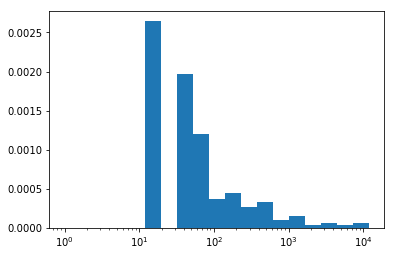

0...
MRR is 0.0034739869467947577
Precision@10 is 0.0
MRR@10 is 0.0


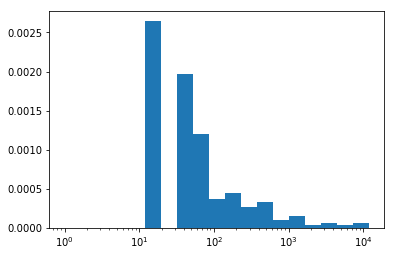

In [40]:
res = runall()

In [41]:
print(datetime.datetime.now().isoformat())

2017-11-12T15:29:50.261979


In [42]:
# 1M lines
# loss: ranking 0%, rating 100%
# all star ratings are considered watched
# centered the rating data around 0
# lambda = 5e-6
# 10 epochs
res

defaultdict(<function __main__.runall.<locals>.<lambda>>,
            {1e-06: defaultdict(list,
                         {'accuracy': [(0.24489795,
                            0.55761719,
                            0.37908566,
                            0.90816867)],
                          'mrr': [0.0034739869467947577,
                           0.0034739869467947577],
                          'mrr_at_10': [0.0, 0.0],
                          'precision_at_10': [0.0, 0.0]})})

In [33]:
# 1M lines
# ranking and rating 50% each
# all star ratings are considered watched
# centered the rating data around 0
# lambda = 5e-6
# 10 epochs
res

defaultdict(<function __main__.runall.<locals>.<lambda>>,
            {1e-06: defaultdict(list,
                         {'accuracy': [(0.46938777,
                            0.61328125,
                            0.38906783,
                            0.90203112)],
                          'mrr': [0.0062781847316484632,
                           0.0062781847316484632],
                          'mrr_at_10': [0.0025000000000000001,
                           0.0025000000000000001],
                          'precision_at_10': [0.02, 0.02]})})

In [38]:
# 1M lines
# loss: ranking 100%, rating 0%
# all star ratings are considered watched
# centered the rating data around 0
# lambda = 5e-6
# 10 epochs
res

defaultdict(<function __main__.runall.<locals>.<lambda>>,
            {1e-06: defaultdict(list,
                         {'accuracy': [(0.75510204,
                            0.70117188,
                            4.3681498,
                            2.5989952)],
                          'mrr': [0.013684247847832686, 0.013684247847832686],
                          'mrr_at_10': [0.0033333333333333331,
                           0.0033333333333333331],
                          'precision_at_10': [0.02, 0.02]})})

In [42]:
# 1M lines
# loss: ranking 0%, rating 100%
# all star ratings are considered watched
# centered the rating data around 0
# lambda = 5e-6
# 10 epochs
res

defaultdict(<function __main__.runall.<locals>.<lambda>>,
            {1e-06: defaultdict(list,
                         {'accuracy': [(0.24489795,
                            0.55761719,
                            0.37908566,
                            0.90816867)],
                          'mrr': [0.0034739869467947577,
                           0.0034739869467947577],
                          'mrr_at_10': [0.0, 0.0],
                          'precision_at_10': [0.0, 0.0]})})